* Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
* Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
* После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача
* Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
* Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
#%pip install pandahouse
#%pip install seaborn
#%pip install swifter
#%pip install scipy

In [2]:
import pandas as pd
import pandahouse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import swifter
import hashlib
from scipy import stats
%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '****',
    'user': '****',,
    'database': 'simulator_20230720'
}

q = """
SELECT  user_id ,
        exp_group,
        sum(action = 'like') likes,
        sum(action = 'view') views,
        likes/views ctr
FROM simulator_20230720.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06' and exp_group in (0, 1, 2, 3)
GROUP by exp_group, user_id
"""

users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df.head()

,user_id,exp_group,likes,views,ctr
0,18392,1,7,32,0.218750
1,115383,3,12,44,0.272727
2,131473,2,9,108,0.083333
3,123580,3,2,11,0.181818
4,32420,2,13,44,0.295455


In [4]:
print(f'Количественное соотношение юзеров в группах:')
users_df.groupby('exp_group').count()

Количественное соотношение юзеров в группах:


,user_id,likes,views,ctr
exp_group,,,,
0,9920,9920,9920,9920
1,10020,10020,10020,10020
2,9877,9877,9877,9877
3,10002,10002,10002,10002


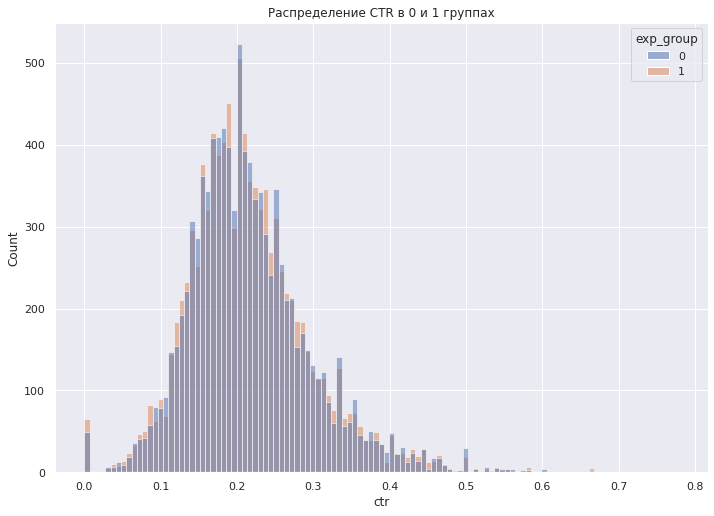

In [7]:
# Нарисуем ctr для подвыборок 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = users_df[(users_df['exp_group'] == 0) | (users_df['exp_group'] == 1)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 0 и 1 группах')
plt.show()

Распределение в группах 0 и 1 на глаз совпадают, поэтому возьмем в качестве контрольной группы в паре (0, 3) 0 группу.

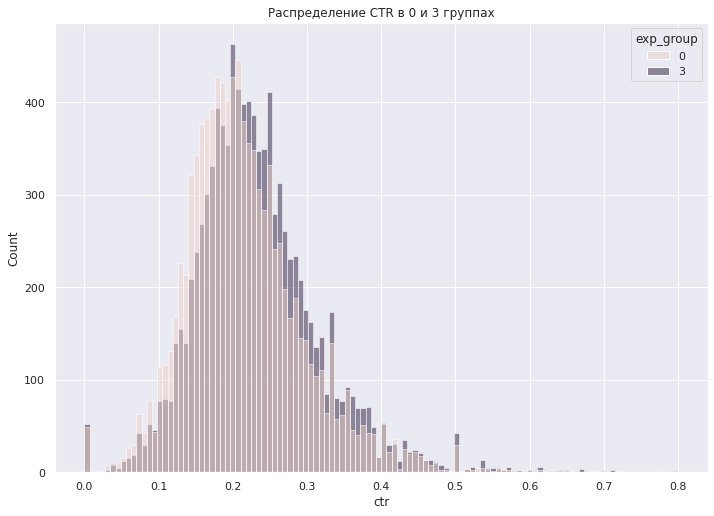

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = users_df[(users_df['exp_group'] == 0) | (users_df['exp_group'] == 3)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 0 и 3 группах')
plt.show()

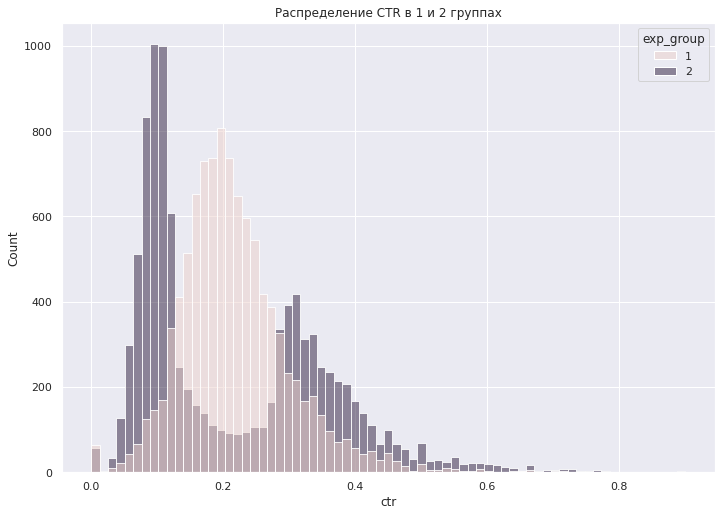

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = users_df[(users_df['exp_group'] == 1) | (users_df['exp_group'] == 2)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 1 и 2 группах')
plt.show()

Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
После чего сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [10]:
# Посчитаем контрольный ctr для всех групп
sum_likes_views = users_df[['likes', 'views', 'exp_group']].groupby('exp_group').sum(['likes', 'views'])
ctr_control = sum_likes_views['likes']/sum_likes_views['views']
ctr_control

exp_group
0    0.209838
1    0.209604
2    0.200251
3    0.226207
dtype: float64

In [11]:
# Функция для линеаризации лайков
def linearized_likes(user_likes, user_views, ctr_control):
    return  (user_likes - ctr_control * user_views)

# Функция для проведения т-теста на линейризованных лайках. Сразу с отрисовкой
def t_test_linearized_likes(users_df, ctr_control, n_control_group=0, n_test_group=3):
    group_control = users_df[users_df.exp_group == n_control_group].copy()
    group_control['linearized_ctr'] = group_control.apply(
        lambda x: linearized_likes(x['likes'], x['views'], ctr_control[n_control_group]), axis=1)

    group_test = users_df[users_df.exp_group == n_test_group].copy()
    group_test['linearized_ctr'] = group_test.apply(
        lambda x: linearized_likes(x['likes'], x['views'], ctr_control[n_control_group]), axis=1)

    hist = sns.histplot(group_control.linearized_ctr, 
                        kde = False,
                        color = 'b')
    hist = sns.histplot(group_test.linearized_ctr, 
                        kde = False,
                        color = 'r',
                        alpha = 0.5)
    hist.legend(['linearized_ctr_control', 'linearized_ctr_test'])
    plt.show()
    
    t_test = stats.ttest_ind(group_control.linearized_ctr,
                             group_test.linearized_ctr,
                             equal_var=False)
    print(f'\nТ-тест на линеаризованном ctr: \n{t_test}\n')
    if t_test[1] < 0.05:
        print(f'Нулевая гипотеза НЕ ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} отличаются')
    else:
        print(f'Нулевая гипотеза ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} НЕ отличаются')
    
    return group_control, group_test

# Группы 0 и 3

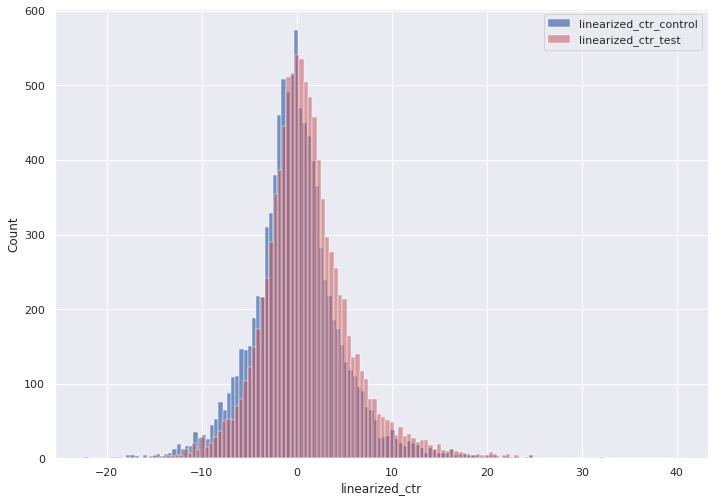


Т-тест на линеаризованном ctr: 
Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

Нулевая гипотеза НЕ ВЕРНА => средние CTR в группах 0 и 3 отличаются


In [12]:
group_control, group_test = t_test_linearized_likes(users_df, ctr_control, n_control_group=0, n_test_group=3)

In [13]:
n_control_group=0
n_test_group=3
t_test = stats.ttest_ind(users_df[users_df.exp_group == n_control_group].ctr,
                         users_df[users_df.exp_group == n_test_group].ctr,
                         equal_var=False)
print(f'\nТ-тест на обычном ctr: \n{t_test}\n')
if t_test[1] < 0.05:
    print(f'Нулевая гипотеза Н0 НЕ ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} отличаются')
else:
    print(f'Нулевая гипотеза Н0 ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} НЕ отличаются')


Т-тест на обычном ctr: 
Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

Нулевая гипотеза Н0 НЕ ВЕРНА => средние CTR в группах 0 и 3 отличаются


### t-тесты на обычном ctr и на линеаризованном показали, что группы 0 и 3 отличаются. p-value на линейризовааном ctr уменьшилось.

# Группы 1 и 2

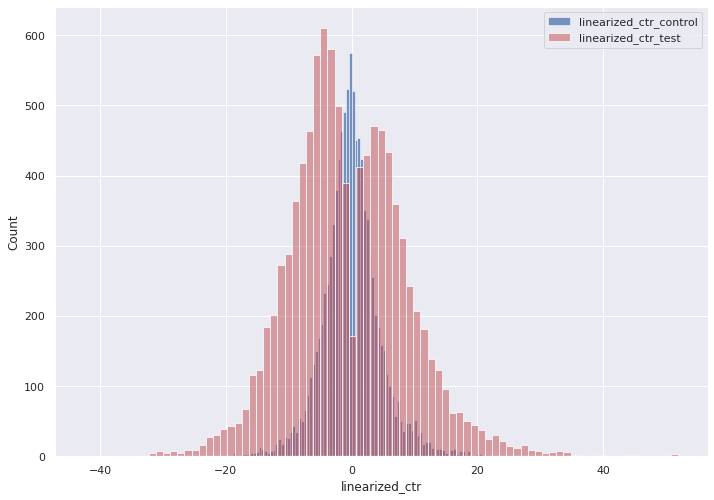


Т-тест на линеаризованном ctr: 
Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

Нулевая гипотеза НЕ ВЕРНА => средние CTR в группах 1 и 2 отличаются


In [14]:
group_control, group_test = t_test_linearized_likes(users_df, ctr_control, n_control_group=1, n_test_group=2)

In [15]:
n_control_group=1
n_test_group=2
t_test = stats.ttest_ind(users_df[users_df.exp_group == n_control_group].ctr,
                         users_df[users_df.exp_group == n_test_group].ctr,
                         equal_var=False)
print(f'\nТ-тест на обычном ctr: \n{t_test}\n')
if t_test[1] < 0.05:
    print(f'Нулевая гипотеза НЕ ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} отличаются')
else:
    print(f'Нулевая гипотеза ВЕРНА => средние CTR в группах {n_control_group} и {n_test_group} НЕ отличаются')


Т-тест на обычном ctr: 
Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

Нулевая гипотеза ВЕРНА => средние CTR в группах 1 и 2 НЕ отличаются


### На группах 1 и 2 t-тест на линеаризованном ctr показал различия между группами, и они правда есть. Р-value значительно уменьшилось относительно результата на обычном ctr. 
### Таким образом, метрика линеаризованных лайков очень хорошо себя зарекомендовала на рассмотренных распределениях, даже в том случае, когда средние выборок совпадали, несмотря на разный характер распредления данных в выборках.